# (sqrt) **Random Forest** 

---

## 0. Importing dependencies

In [254]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [255]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [256]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_New Zealand', 'Country_Lebanon', 'Country_Saudi Arabia', 'Country_Yemen', 'Country_Latvia', 'Country_Venezuela', 'Country_Botswana', 'Country_Costa Rica', 'Country_Azerbaijan', 'Country_Kosovo', 'Country_Croatia', 'Country_Bosnia-Herz.', 'Country_Nomadic', 'Country_Kenya', 'Country_Bangladesh', 'Country_Paraguay', 'Country_Zimbabwe', 'Country_Sri Lanka', 'Country_Serbia', 'Country_Jordan', 'Country_Angola', 'Country_Andorra', 'Country_Slovakia', 'Country_Peru', 'Ethnicity_North American / Central American', 'Country_Philippines', 'Country_Cyprus', 'Country_Tanzania', 'Country_Georgia', 'Country_United Arab Emirates', 'Country_Uzbekistan', 'Country_North Macedonia', 'Country_El Salvador', 'Country_Mongolia', 'Country_Armenia', 'Country_Estonia', 'Country_Malta', 'Country_Viet Nam'}
Columns in the test set that aren't in the train set: {'Country_Guinea', 'Country_Senegal', "Country_CÃ´te d'Ivoire", 'Country_Trinidad and Toba

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [257]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,Country_Belgium,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Colombia,Country_Czech Republic,Country_Denmark,Country_Dominican Republic,Country_Ecuador,Country_Egypt,Country_Finland,Country_France,Country_Germany,Country_Greece,Country_Hong Kong,Country_Hungary,Country_India,Country_Indonesia,Country_Iran,Country_Ireland,Country_Israel,Country_Italy,Country_Japan,Country_Kazakhstan,Country_Lithuania,Country_Luxembourg,Country_Malaysia,Country_Mexico,Country_Morocco,Country_Netherlands,Country_Nigeria,Country_Norway,Country_Pakistan,Country_Poland,Country_Portugal,Country_Romania,Country_Russian Federation,Country_Singapore,Country_Slovenia,Country_South Africa,Country_South Korea,Country_Spain,Country_Sweden,Country_Switzerland,Country_Taiwan,Country_Thailand,Country_Turkey,Country_UK & Northern Ireland,Country_USA,Country_Ukraine,Country_Uruguay,Academic researcher,Blockchain,Cloud infrastructure engineer,Data or business analyst,Data scientist or machine learning specialist,Database administrator,Designer,DevOps specialist,"Developer, QA or test","Developer, back-end","Developer, desktop or enterprise applications","Developer, embedded applications or devices","Developer, front-end","Developer, full-stack","Developer, game or graphics","Developer, mobile",Educator,"Engineer, data","Engineer, site reliability",Engineering manager,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,12.2,62820.0


In [258]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = np.sqrt(baseline_train_df['Annual_salary'])
y_test = np.sqrt(baseline_test_df['Annual_salary'])

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2258, 92)
(2258,)

(553, 92)
(553,)


---

### 2.2. Identifying the target

In [259]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = np.sqrt(train_df['Annual_salary'])
# y_test = np.sqrt(test_df['Annual_salary'])
# #y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [260]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importance
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [261]:
model = RandomForestRegressor(random_state=42)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    "n_estimators": randint(150, 800),
    "max_features": randint(30, X_train_scaled.shape[1]//2), # Reducido
    "max_depth": randint(20, 30), # Reducido
    "min_samples_split": randint(2, 12), # Ampliado un poco
    "min_samples_leaf": randint(3, 5), # Reducido
    "bootstrap": [True],
}

def custom_rmse(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    mse = mean_squared_error(y_true_original, y_pred_original)
    return np.sqrt(mse)

def custom_r2(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    return r2_score(y_true_original, y_pred_original)

custom_scorer = {'r2': make_scorer(custom_r2, greater_is_better=True),  
                 'rmse': make_scorer(custom_rmse, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=custom_scorer, return_train_score=True,
                   n_jobs=-1, random_state=42, verbose=2)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


Best parameters found: {'bootstrap': True, 'max_depth': 29, 'max_features': 35, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 710}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [262]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.759603,0.608373,24932.807942,31771.693247
1,0.774244,0.608748,24161.513727,31753.504876
2,0.739433,0.604552,25957.168450,31918.375654
3,0.739051,0.605530,25976.210165,31878.309364
4,0.735754,0.603779,26139.621531,31950.813354
5,0.758175,0.610081,25006.515377,31696.323551
6,0.756665,0.605575,25084.344256,31878.758719
7,0.790706,0.607447,23264.123654,31806.138571
8,0.754656,0.608969,25187.377017,31745.053585
9,0.770585,0.607857,24356.412214,31789.596381


Now, the average of folds:

In [263]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  
mean_train_r2 = np.mean(df_cv_results['mean_train_r2']) 
mean_train_rmse = np.mean(df_cv_results['mean_train_rmse'])
 
print(f"Mean CV Train R2: {mean_train_r2}")
print(f"Mean CV Train RMSE: {mean_train_rmse}")
print('-'*20)
print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Train R2: 0.757887389149997
Mean CV Train RMSE: 25006.609433246726
--------------------
Mean CV Test R2: 0.6070909972808709
Mean CV Test RMSE: 31818.856730115505


In [264]:
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  

for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = {
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    
        }
        results_df = results_df.append(fold_results, ignore_index=True)

results_df.index += 1
results_df.index.name = 'Fold'
results_df

,train_r2,test_r2,train_rmse,test_rmse
Fold,,,,
1,0.763567,0.574691,24937.948694,32285.697227
2,0.777897,0.57255,24170.370302,32366.846348
3,0.743348,0.564381,25982.394979,32674.666523
4,0.742189,0.565506,26040.993018,32632.44898
5,0.74013,0.56432,26144.752566,32676.965728
6,0.762105,0.572217,25014.908617,32379.447565
7,0.759755,0.567999,25138.184455,32538.687505
8,0.793322,0.570583,23315.975703,32441.228013
9,0.759446,0.572545,25154.32679,32367.052142


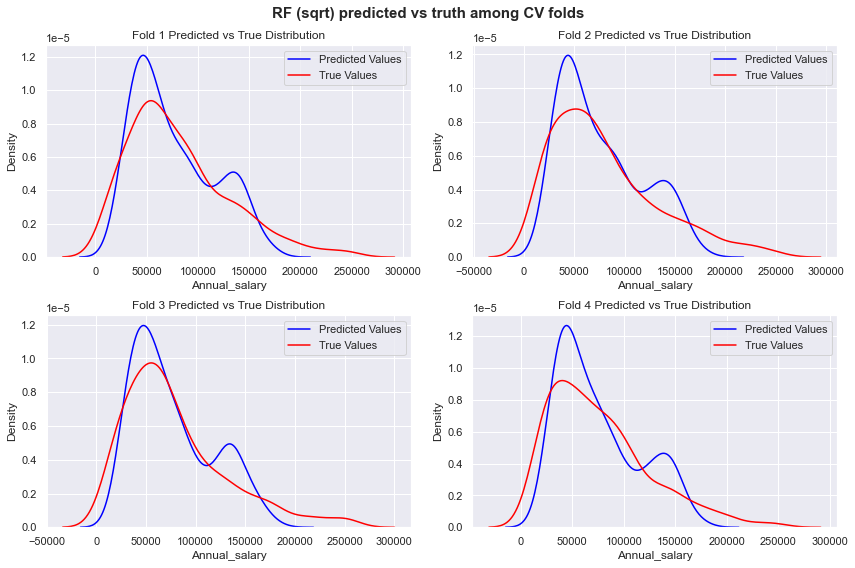

In [265]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    y_fold_pred = clf.predict(X_fold_test)

    plt.subplot(2, 2, fold_num)
    sns.kdeplot(np.power(y_fold_pred,2), color='blue', label='Predicted Values')
    sns.kdeplot(np.power(y_fold_true,2), color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.suptitle('RF (sqrt) predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [266]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y_true, inverse_transform=True):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    if inverse_transform:
        y_pred = np.power(y_pred, 2)  
        y_true = np.power(y_true, 2) 
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train/Test set results


Train set metrics:
R^2: 0.7615571194306588
RMSE: 24834.675678314412
Adjusted R^2: 0.7514246736974581


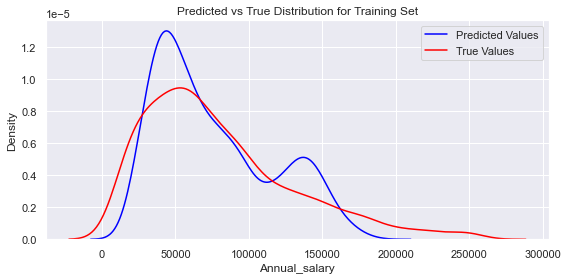

In [267]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")

y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(np.power(y_train_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_train,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.6489820177864363
RMSE: 29358.365179367665
Adjusted R^2: 0.5787784213437235


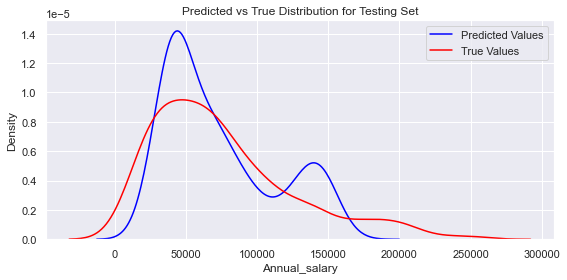

In [268]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")

y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(np.power(y_test_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_test,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [269]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

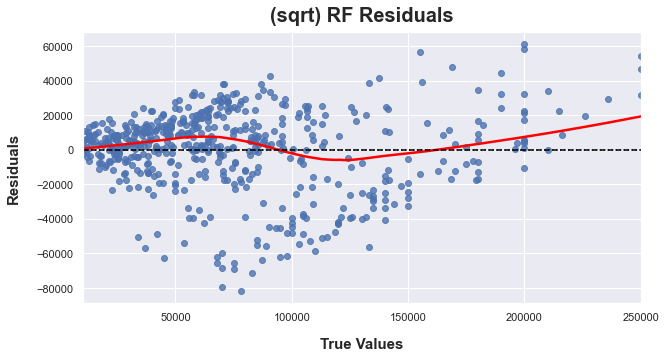

In [270]:
sns.set_theme(style='darkgrid')

residuals = np.power(y_test, 2) - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=np.power(y_test, 2), y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('(sqrt) RF Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/sqrt-rf-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 720x432 with 0 Axes>

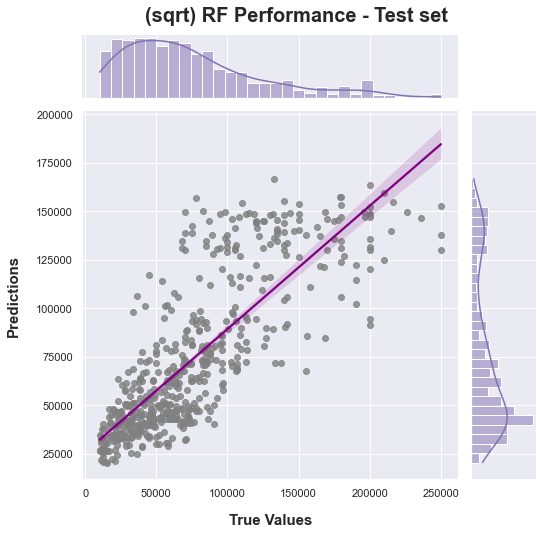

In [271]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=np.power(y_test, 2), y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('(sqrt) RF Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-rf-test-predictions.pdf");

## 6. Saving results

Saving CV results

In [272]:
df_cv_results.to_csv("../../output/sqrt-rf-cv-results.csv")

Saving train and test sets predictions

In [273]:
np.savetxt("../../output/sqrt-rf-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/sqrt-rf-test-predictions.csv", y_pred_test, delimiter=",")

In [274]:
pd.set_option('display.max_colwidth', None)

df_cv_results[['params', 'mean_train_r2', 'mean_test_r2','mean_train_rmse', 'mean_test_rmse']]


,params,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,"{'bootstrap': True, 'max_depth': 26, 'max_features': 33, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 170}",0.759603,0.608373,24932.807942,31771.693247
1,"{'bootstrap': True, 'max_depth': 26, 'max_features': 39, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 480}",0.774244,0.608748,24161.513727,31753.504876
2,"{'bootstrap': True, 'max_depth': 27, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 280}",0.739433,0.604552,25957.168450,31918.375654
3,"{'bootstrap': True, 'max_depth': 25, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 641}",0.739051,0.605530,25976.210165,31878.309364
4,"{'bootstrap': True, 'max_depth': 25, 'max_features': 31, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 310}",0.735754,0.603779,26139.621531,31950.813354
5,"{'bootstrap': True, 'max_depth': 29, 'max_features': 35, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 710}",0.758175,0.610081,25006.515377,31696.323551
6,"{'bootstrap': True, 'max_depth': 29, 'max_features': 45, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 716}",0.756665,0.605575,25084.344256,31878.758719
7,"{'bootstrap': True, 'max_depth': 23, 'max_features': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 634}",0.790706,0.607447,23264.123654,31806.138571
8,"{'bootstrap': True, 'max_depth': 22, 'max_features': 36, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 316}",0.754656,0.608969,25187.377017,31745.053585
9,"{'bootstrap': True, 'max_depth': 21, 'max_features': 33, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 495}",0.770585,0.607857,24356.412214,31789.596381


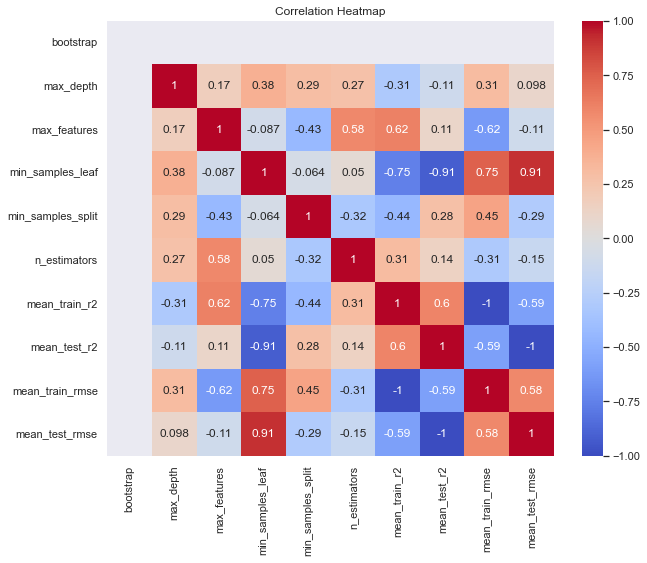

In [275]:
df_subset = df_cv_results[['params', 'mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]

# Extraer las características de la columna 'params' en columnas individuales
params_df = df_subset['params'].apply(pd.Series)
df_processed = pd.concat([params_df, df_subset[['mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]], axis=1)

# Convertir valores de 'bootstrap' a números
df_processed['bootstrap'] = df_processed['bootstrap'].astype(int)

# Calcular la correlación de Pearson
corr = df_processed.corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [276]:
corr

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
bootstrap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_depth,NaN,1.000000,0.169804,0.381096,0.294611,0.268649,-0.305747,-0.110268,0.310261,0.098410
max_features,NaN,0.169804,1.000000,-0.086940,-0.432362,0.582372,0.615128,0.108540,-0.617528,-0.107102
min_samples_leaf,NaN,0.381096,-0.086940,1.000000,-0.063758,0.050399,-0.752535,-0.914465,0.745719,0.906464
min_samples_split,NaN,0.294611,-0.432362,-0.063758,1.000000,-0.323505,-0.444004,0.281187,0.448817,-0.290203
n_estimators,NaN,0.268649,0.582372,0.050399,-0.323505,1.000000,0.306727,0.136839,-0.307529,-0.152094
mean_train_r2,NaN,-0.305747,0.615128,-0.752535,-0.444004,0.306727,1.000000,0.600670,-0.999815,-0.591402
mean_test_r2,NaN,-0.110268,0.108540,-0.914465,0.281187,0.136839,0.600670,1.000000,-0.589681,-0.999673
mean_train_rmse,NaN,0.310261,-0.617528,0.745719,0.448817,-0.307529,-0.999815,-0.589681,1.000000,0.580410
mean_test_rmse,NaN,0.098410,-0.107102,0.906464,-0.290203,-0.152094,-0.591402,-0.999673,0.580410,1.000000
